<a href="https://colab.research.google.com/github/Sharon972/me/blob/Data_science_cursillo_july/06_Introducci%C3%B3n_a_Stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: Introducción a Stable Diffusion 🧨

Adaptado de:

- \[1\] [Stable Diffusion 🎨 - Hugging Face](https://huggingface.co/blog/stable_diffusion)
- \[2\] [Getting started with 🧨 Diffusers](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb)
- \[3\] [Stable Diffusion - Google Colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb)
- \[4\] [Gradio - Quickstart 🚀](https://gradio.app/quickstart/)

## Parte 1: Stable Diffusion

Stable Diffusion es un modelo de difusión latente texto-a-imagen creado por los ingenieros de [CompisVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) y [LAION](https://laion.ai/). Esta entrenado sobre imagenes de $512 \times 512$ píxeles que vienen de una base de datos llamada [LAION-5B](https://laion.ai/blog/laion-5b/) [1].

En esta parte vamos a ver como utilizar Stable Diffusion con la [librería 🧨 Diffusers](https://github.com/huggingface/diffusers), explicar como un funciona el modelo y aprender un poco sobre como _diffusers_ permite a uno customizar la generación de imágenes.

### 1.1. ¿Qué son los modelos de difusión?

Los modelos de difusión son sistemas de Machine Learning que son entrenados para _remover el ruido_ gaussiano paso a paso, para obtener una muestra de interes, como una imagen.

El modelo que opera por debajo, normalmente una red neuronal, es entrenado para predecir una manera de eliminar un poco de ruido en cada paso. Despues de una cantidad de pasos, se obtiene una muestra. [2]

El proceso se ilustra de la siguiente manera:


![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusion-process.png)

La arquitectura de la red neuronal, normalmente referido como **modelo**, comunmente sigue la arquitectura UNet como se propone en [este paper](https://arxiv.org/abs/1505.0459).


![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

No es necesario entender esta arquitectura, pero en resumen, lo que hace UNet es:
    
- Predecir imágenes del mismo tamaño que la entrada
- Pasar la imagen por varios bloques de capas de ResNet que achican la imagen por la mitad de su tamaño.
- Luego por la misma cantidad de bloques, se vuelve agrandar la imagen de nuevo
- Y las conexiones que pasan de los bloques de _downsample_ al _upsample_ permiten pasar las características de la imagen por la red.

### 1.2. ¿Cómo usar Stable Diffusion?

Primero debemos instalar las librerías de Python para poder correr los bloques de código:

In [1]:
#Stable Diffusion implementa la arquitectura transformers
!pip install -q -U transformers diffusers==0.14.0 accelerate ftfy fpuna-stable-diffusion gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Lo bueno de **🧨Diffusers** es que permite correr el modelo de Stable Diffusion con muy pocas líneas de código. Para esto se utiliza el pipeline [StableDiffusionPipeline](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py). Este _pipeline_ confirgura todo lo necesario para generar imágenes desde texto con una simple llamada a la función __from_pretrained__. Esta función va a descargar el modelo desde **Hugging Face**

In [2]:
import torch

#DE LA LIBRERÍA diffusers IMPORTO LA CLASE StableDiffusionPipeline (usada para generación de imagenes)

from diffusers import StableDiffusionPipeline

#CREO LA INSTANCIA pipe y con el método .from_pretrained() cargo el modelo preentrenado "runwayml/st.."

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
#torch_dtype=torch.float16 me indica q debo tratar los datos como números de flotante 16 bits en lugar de la predeterminada float32
#lo que ayudaría a reducir el uso de memoria y acelerar las operaciones

#OJO SE RECOMIENDA USAR float16 cuando uso un MODELO PREENTRENADO, igual revisar la documentación de las librerías


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Si esta disponible la GPU, hay que mover el modelo allí para acelerar la generación de imágenes. Con el siguiente comando podemos ver que GPU tenemos:

MOVEMOS EL MODELO A LA GPU

In [3]:
#16376MiB SIGNIFICA LOS mb de la ram
!nvidia-smi

Thu Jul 27 16:57:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

PASAMOS EL PIPELINE DE STABLEDIFFUSION AL GPU

In [4]:
pipe = pipe.to("cuda")

**Nota:** Si estas límitado por la memoria de la GPU y tienes menos de 10GB de GPU RAM disponible, debes cargar el `StableDiffusionPipeline` con precisión float16 como lo hicimos arriba, sino puedes omitirlo y correrlo de la siguiente manera:

In [ ]:
# Cargar el pipeline con menor precisión (Solo si tienes más de 10GB de GPU RAM)
#import torch
#from diffusers import StableDiffusionPipeline
#pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
#pipe.to("cuda")

Para correr el pipeline, simplemente debemos crear el prompt y llamar al `pipe`. Prueba distintos textos como:

- "an orange with wings in a field, digital art" (Una naranja con alas en un campo, arte dígital)
- "a photograph of an astronaut riding a horse" (La fotografía de un astronauta montando un caballo)
- "red dress mannequin, gorgeous ,ultra hd, realistic, full dress, 8k" (Maniquí vestido rojo, hermoso, ultra hd, realistico, vestido completo, 8k)

GENERAMOS EL PROMPT(QUE ES UNA ORACIÓN) Y PASAMOS POR NUESTRO MODELO ESE PROMPT

Acá como no le colocamos una semilla, cada vez que se corra el código, saldrán distintas imagenes.

In [10]:
# La fotografía de un astronauta montando un caballo

#PROMPT ES SOLICITUD
prompt = "a photograph of an astronaut riding a horse"

image = pipe(prompt).images[0] #AL pipe le pasamos el texto y colocamos images[0] para poder visualizar la imagen cuando la llamemos

#ME SALE 50, 50 POR QUE EL RUIDO SE LIMPIÓ 50 VECES HASTA QUE SE GENERÓ ESA IMAGEN
#SALE UNA IMAGEN DISTINTA POR QUE SE USO UN RUIDO DIFERENTE

  0%|          | 0/50 [00:00<?, ?it/s]

Se debería de ver algo así:

VISUALIZAMOS LO QUE SOLICITAMOS EN EL PROMPT

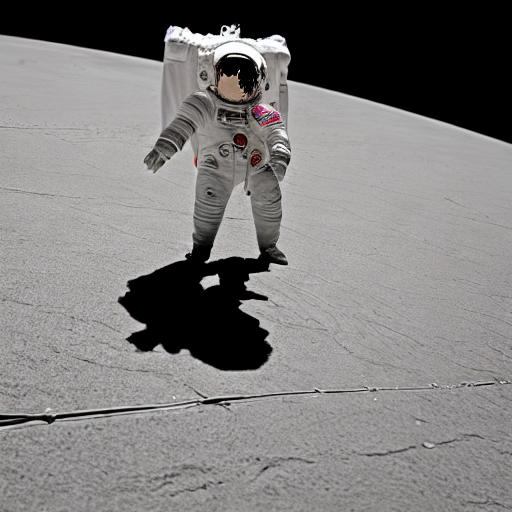

In [13]:
image

Cada que vez que corramos el código, tendremos una imagen distinta. Si queremos  tener la misma salida siempre, podemos pasar una semilla al pipeline. Cada vez que uses la misma semilla, obtendrás la misma imagen de salida.

COLOCAMOS UN SEMILLA(PARA QUE TENGAMOS SIEMPRE LA MISMA SALIDA)

  0%|          | 0/50 [00:00<?, ?it/s]

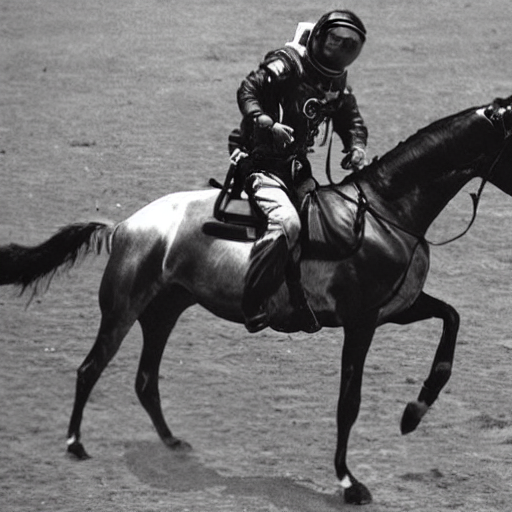

In [23]:
semilla = 1024 #Se elige el número por conveniencia o preferencia

#CREO UN GENERADOR DE NÚMEROS ALEATORIOS USANDO LA SEMILLA DE ARRIBA

#En torch.Generator colocamos cuda xq los números aleatorios que se generarán se harán usando GPU

generator = torch.Generator("cuda").manual_seed(semilla)#manual_seed asigna la semilla al generador

image = pipe(prompt, guidance_scale=6.5, generator=generator).images[0]#guidance_scale lo uso para indicar el
#grado de influencia del prompt en la imagene generada.
#generator=generator dice el generador de números aleatorios creado antes se pasa como argumento adicional al modelo.

# PUDES GUARDAR LA IMAGEN CON:
# image.save(f"astronaut_rides_horse.png")

#OJO PUEDES JUGAR CON guidance_scale (JUEGA ENTRE HACERLE CASO AL TEXTO) O CON la semilla

image

Podemos cambiar la cantidad de pasos de inferencia utilizando el argumento `num_inference_steps`.

En general, los resultados son mejores cuando más pasos uses, sin embargo, cuando más pasos, más tarda en generar la imagen. Stable Diffusion funciona bastante bien con una cantidad relativamente pequeña de pasos, por lo que $50$ pasos es la cantidad predeterminada.

Probemos el `pipeline` con menos cantidad de pasos.

  0%|          | 0/70 [00:00<?, ?it/s]

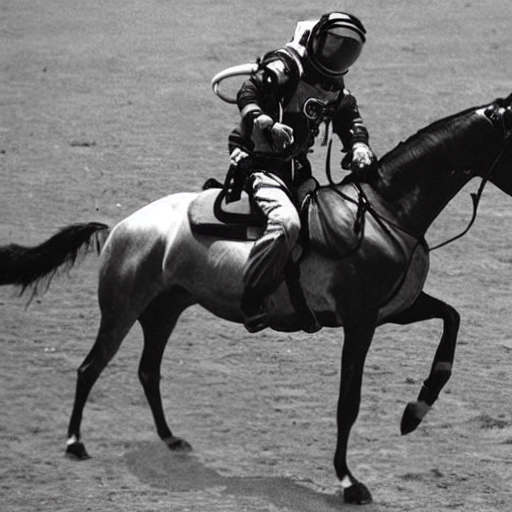

In [27]:
generator = torch.Generator("cuda").manual_seed(semilla)

#INDICAMOS CUANDO PASOS USAMOS PARA LIMPIAR EL RUIDO

#num_inference_steps=10 (solo habrán 10 pasos de limpieza, pero baja la calidad)

image = pipe(prompt, guidance_scale=7.5, num_inference_steps=70, generator=generator).images[0]

# Puedes guardar la imagen con:
# image.save(f"astronaut_rides_horse.png")

image

Notamos que la calidad es menor, aunque mantiene la misma estructura de la imagen.

A parte de `num_inference_steps`, hemos utilizado otro argumento llamado `guidance_scale`. Este argumento nos permite aumentar la adherencia a la señal condicional que guia la generación de imagen (texto, en este caso), así como también la calidad de la imagen. Se conoce también como [classifier-free guidance](https://arxiv.org/abs/2207.12598), que en términos más simples, fuerza la generación de imagen a que coincida más con el texto a costas de perder calidad de imagen.

IMPRIMO MÁS DE UNA IMAGEN (CADA IMAGEN LO GUARDAMOS EN UN VECTOR)

In [ ]:
#IMPORTO UNA FUNCIÓN DE APOYO PARA IMPRIMIR VARIAS IMAGENES (uso image_grid)(GRID ES CUADRÍCULA)
!pip install fpuna_stable_diffusion

In [ ]:
from fpuna_stable_diffusion.utils import image_grid
num_images = 4 #Número de imagenes que se generan
prompt = "a photograph of an astronaut riding a horse"
images = []#Creo una lista vacía

for i in range(num_images):
    images.append(pipe(prompt).images[0])

grid = image_grid(images, rows=1, cols=num_images)

# Puedes guardar la imagen con:
# grid.save(f"astronaut_rides_horse.png")

grid

HAGO UN PROMPT MÁS DE UNA VEZ

In [ ]:
nuevas = pipe(("an astronaut", "a dog")).images

#MUESTRO LAS DOS IMAGENES

image_grid(nuevas, rows=1, cols= 2 )

Por defecto, Stable Diffusion produce imágenes de $512 \times 512$ píxeles. Esta configuración se puede sobreescribir facilmente utilizando los argumentos `height` (altura) y `width` (anchura).

Cuando se eligen los tamaños de las imágenes, se recomienda lo siguiente:

- Asegurarse que ambos `height` (altura) y `width` (anchura), sean multiplos de $8$.
- Ir por debajo de $512$ puede resultar en imágenes de menor calidad
- Ir por encima de $512$ en ambas direcciones hará que se repitan áreas de la imagen (coherencia global es perdida)
- La mejor forma de crear imágenes que no sean cuadradas es usar $512$ en una dimensión y un valor mayor a este en la otra.

LE CAMBIO EL TAMAÑO A MI IMAGEN

  0%|          | 0/50 [00:00<?, ?it/s]

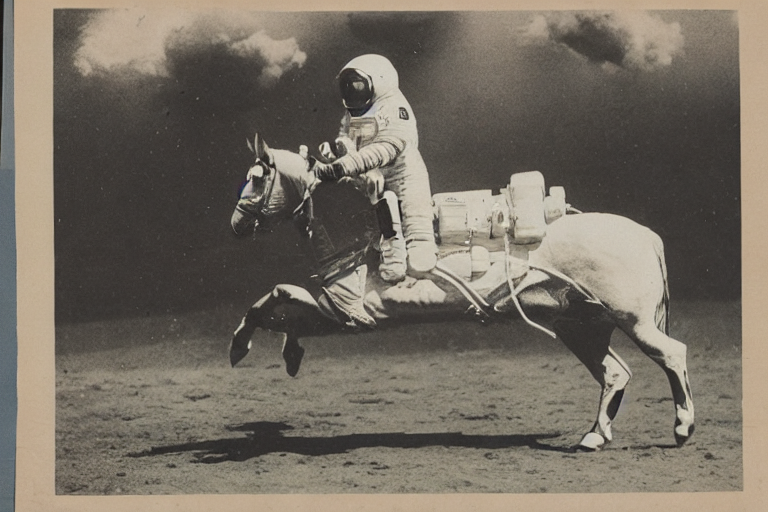

In [ ]:
prompt = "a photograph of an astronaut riding a horse"

image = pipe(prompt, height=512, width=768).images[0] #Tratar de hacer multiplod de 8, esto va muy bien
#Hacer con numeros por debajo de 512 sale menor calidad, no se extrapolan correctamente, si pongo mas de 512 también falla


# PUEDES GUARDAR LA IMAGEN CON:
# image.save(f"astronaut_rides_horse.png")

image

### 1.3. ¿Cómo funciona Stable Diffusion?

Ahora que vimos las imágenes de alta calidad que produce Stable Diffusion, tratemos de entender un poco mejor como funciona el modelo.

Stable Diffusion esta basado en un tipo particular de modelo de difusión llamado **Latent Diffusion**, propuesto en [High-Resolution Image Synthesis with Latent Diffusion Models.](https://arxiv.org/abs/2112.10752)

Los modelos de difusión demostraron que se puede obtener resultados del estado del arte para la generación de imágenes. Pero una de las desventajas de estos modelos es que proceso de eliminación de ruido es lento debido a su naturaleza repetitiva y secuencial. Adicionalmente, estos modelos consumen una gran cantidad de memoria por que operan en el espacio de los píxeles, que es una gran cantidad cuando generamos imágenes de alta resolución. Por ende, es muy dificil entrenar estos modelos y también usarlos para hacer inferencia

**Latent diffusion**

La difusión latente puede reducir la complejidad computacional aplicando el proceso de difusión en un espacio latente de menor dimensión en vez de usar el espacio de píxeles. La diferencia clave entre la difusión estandar y los modelos de difusión latentes es: **en la difusión latente, el modelo es entrenado para generar una representación latente (comprimida) de las imágenes**

Hay 3 componentes principales en la difusión latente:

1. Un Autoencoder (VAE)
2. Un U-Net
3. Un Text Encoder, por ejemplo: CLIP's Text Encoder

#### 1. El Autoencoder (VAE)

El modelo VAE tiene dos partes: el encoder y el decoder. El encoder es el que se encarga de convertir la imagen en una representación latente de baja dimensión, que servirá como entrada al modelo U-Net. El decoder, a su vez, transforma la representación latente de nuevo en una imagen.

#### 2. El U-Net

El U-Net también tiene un _encoder_ y un _decoder_, ambos compuestos por bloques ResNet. El encoder comprime la representación de la imagen en una representación de la imagen de menor resolución, y luego el decoder se encarga de convertir la representación de baja resolución de nuevo a la representación de alta resolución que supuestamente tiene menos ruido.

#### 3. El Text Encoder

El Text Encoder es el responsable de transformar el mensaje de texto, por ejemplo: "Un astronauta montando un caballo" en un _embedding_ que puede ser entendido por el U-Net. Normalmente es un codificador basado en transformadores que convierte una secuencia de tokens de entrada a una secuencia de embeddings de texto latentes.

**Stable Diffusion durante la inferencia**

Uniendo todas las piezas, ahora veamos de cerca como el modelo funciona:

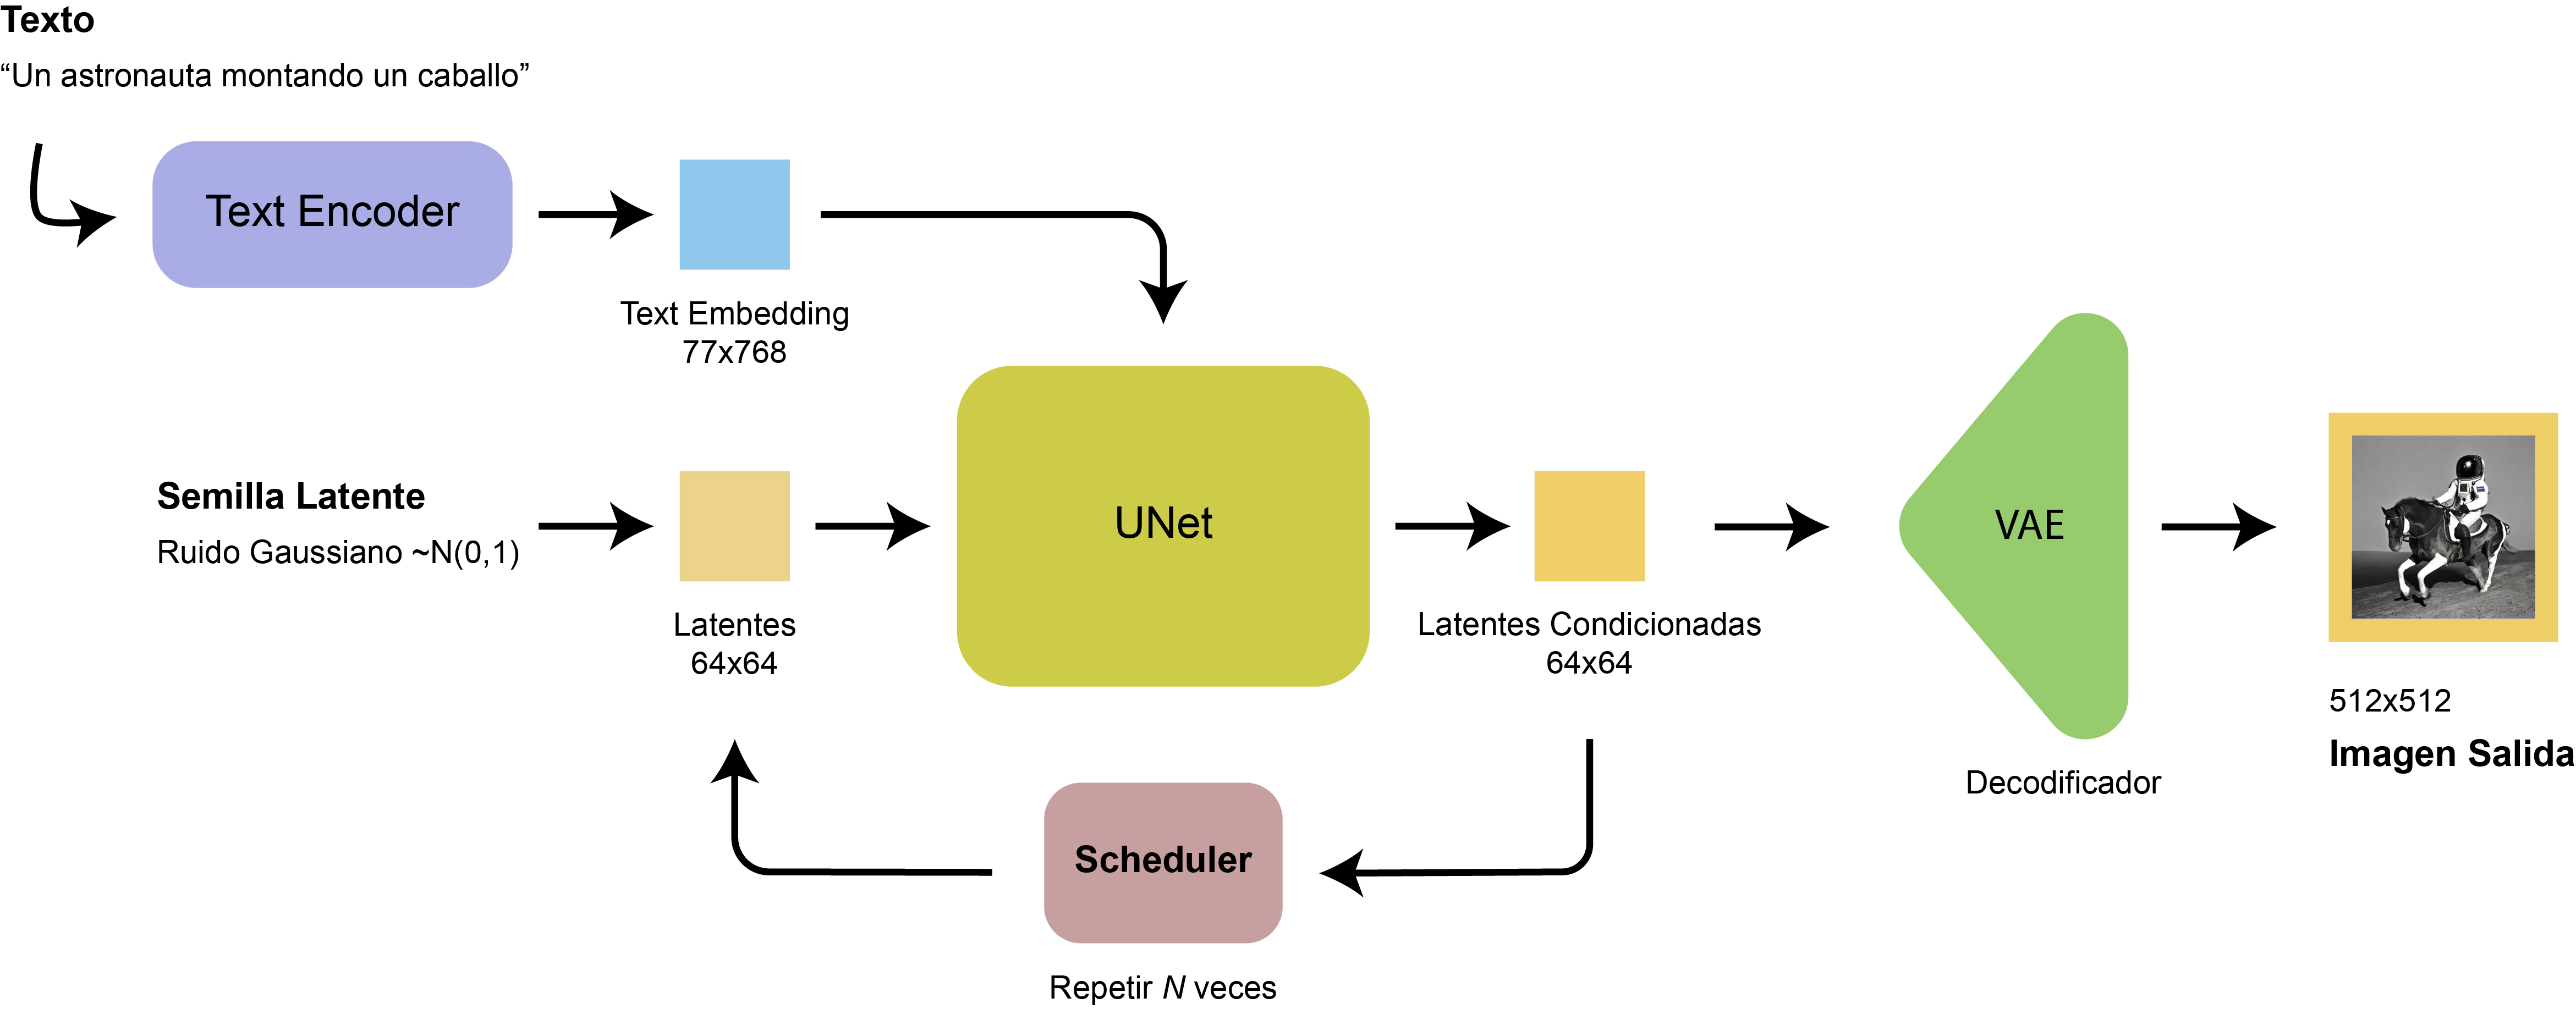

El modelo de Stable Diffusion toma la semilla latente y el texto como entrada. La semilla es utilizada para generar la representación latente de la imagen aleatoria de tamaño $64\times64$ mientras que el texto se transforma en un embedding de $77\times768$. Luego el U-Net remueve el ruido iterativamente mientras toma en cuenta el embedding del texto como condición.

### 1.4. Utilizando Gradio para crear una interfaz

Con Gradio, los desarrolladores pueden crear rápidamente interfaces de usuario para sus modelos de aprendizaje automático y aplicaciones de ciencia de datos sin necesidad de conocimientos en diseño de interfaces gráficas de usuario (GUI). Gradio es una herramienta muy útil para aquellos que desean compartir sus modelos con un público no técnico o para aquellos que desean explorar y visualizar los resultados de sus análisis de datos de una manera más interactiva.

Para utilizar gradio, primero necesitamos crear una función que reciba los datos que necesitamos para generar (prompt, semilla, etc) y que retorne la imagen.

CREO LA FUNCIÓN

In [ ]:
#CREO UNA FUNCIÓN generar_imagen LE DOY EL prompt, el num_interference_steps(pasos de inferencia)

def generar_imagen(prompt, guidance_scale=7.5, num_inference_steps=50, semilla=1234):
    generator = torch.Generator("cuda").manual_seed(semilla)#generador de números aleatorios
    image = pipe(prompt, guidance_scale=guidance_scale, num_inference_steps=num_inference_steps, generator=generator).images[0]
    return image


generar_imagen("a flying pig with white wings")

  0%|          | 0/50 [00:00<?, ?it/s]

Una vez que tengamos nuestra función, podemos usar la API de gradio para crear nuestra interfaz gráfica

LUEGO DE CREAR LA FUNCIÓN LO PASO A GRADIO

In [ ]:
import gradio as gr

demo = gr.Interface(
    fn=generar_imagen, # Función que vamos a utilizar para generar
    title="Stable Diffusion 🧨", # Título
    # Entradas
    inputs=[
        gr.Textbox(value="a flying pig with white wings"), #TEXTO
        gr.Number(value=7.5),
        gr.Number(value=50, precision=0),
        gr.Number(value=1234, precision=0)
    ],
    # Salidas
    outputs="image"
)

demo.launch(share=True)#PARA EJECUTAR, crea la interface en otro servidor